 # Final Project - Image Classification
 #### Brittany Creel
 #### ADSP 31009 Machine Learning and Predictive Analytics
 #### Spring 2024, Thursdays 6-9 PM

 ### Import Packages and Data, Split the Data into Train/Validation/Test

In [2]:
import os
from os import path
import random
import shutil
from shutil import copyfile
from PIL import Image
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
#connect to Google Drive and change the working directory
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Creel ADSP31009 Final Project'

Mounted at /content/drive
/content/drive/My Drive/Creel ADSP31009 Final Project


In [ ]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


In [4]:
pwd()

'/content/drive/My Drive/Creel ADSP31009 Final Project'

In [5]:
# Define paths
source_folder = '/content/drive/MyDrive/Creel ADSP31009 Final Project'
train_folder = os.path.join(source_folder, 'train')
test_folder = os.path.join(source_folder, 'test')
val_folder = os.path.join(source_folder, 'val')
real_folder = os.path.join(source_folder, 'RealArt')
ai_folder = os.path.join(source_folder, 'AiArt')
train_real = os.path.join(train_folder, 'real')
train_ai = os.path.join(train_folder, 'ai')
val_real = os.path.join(val_folder, 'real')
val_ai = os.path.join(val_folder, 'ai')
test_real = os.path.join(test_folder, 'real')
test_ai = os.path.join(test_folder, 'ai')

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(train_real, exist_ok=True)
os.makedirs(train_ai, exist_ok=True)

os.makedirs(test_folder, exist_ok=True)
os.makedirs(test_real, exist_ok=True)
os.makedirs(test_ai, exist_ok=True)

os.makedirs(val_folder, exist_ok=True)
os.makedirs(val_real, exist_ok=True)
os.makedirs(val_ai, exist_ok=True)

# Get lists of images
real_images = os.listdir(real_folder)
ai_images = os.listdir(ai_folder)

 ## Exploratory Data Analysis

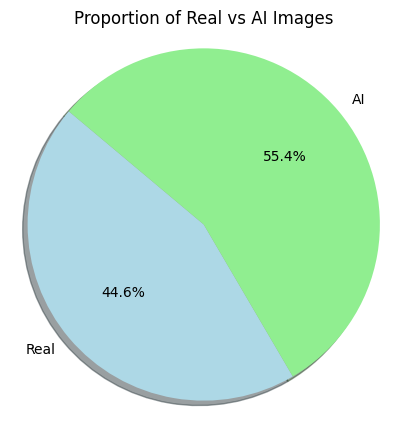

In [ ]:
#how many images in each class?
real_count = len(real_images)
ai_count = len(ai_images)
total_count = real_count + ai_count

# Data for the pie chart
pie_labels = ['Real', 'AI']
pie_sizes = [real_count, ai_count]
pie_colors = ['lightblue', 'lightgreen']

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(pie_sizes, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%',
        shadow=True, startangle=140)

plt.title('Proportion of Real vs AI Images')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

Examples of Real Images:



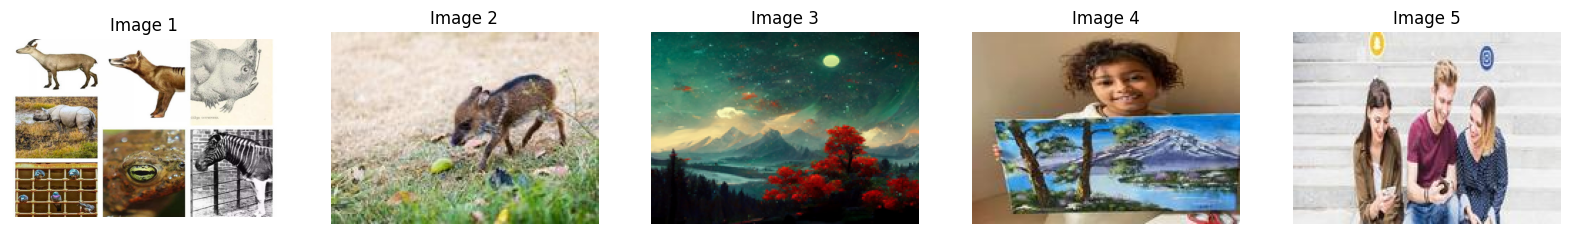

In [ ]:
#preview images from each class
print("Examples of Real Images:")
print() #blank space

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the selected images and plot each one
for i, image_name in enumerate(real_images[:5]):
    # Load the image
    img_path = os.path.join(real_folder, image_name)
    img = Image.open(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Image {i+1}")

# Display the plot
plt.show()

Examples of AI Images:



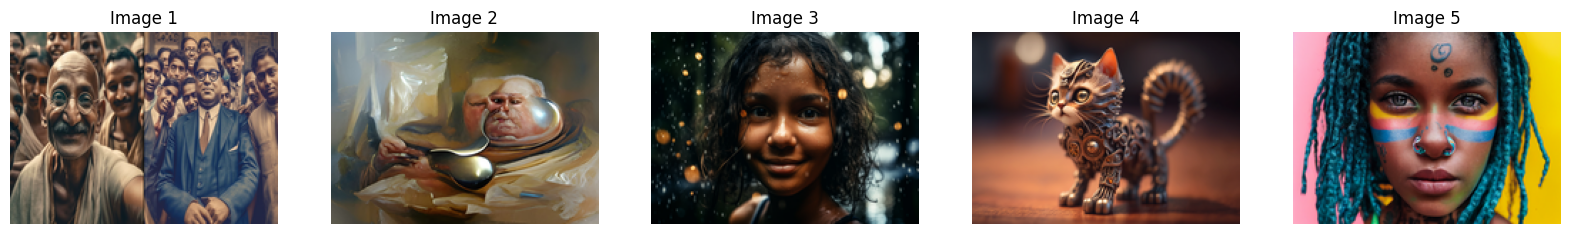

In [ ]:
print("Examples of AI Images:")
print() #blank space

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the selected images and plot each one
for i, image_name in enumerate(ai_images[:5]):
    # Load the image
    img_path = os.path.join(ai_folder, image_name)
    img = Image.open(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Image {i+1}")

# Display the plot
plt.show()

In [6]:
# Initialize a list to store image data
image_sizes = []

# Function to collect image size data
def collect_image_sizes(folder, label):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        with Image.open(img_path) as img:
            width, height = img.size
            channels = len(img.getbands())
            image_sizes.append({
                'label': label,
                'width': width,
                'height': height,
                'channels': channels
            })

# Collect data for real and AI images
collect_image_sizes(real_folder, 'real')
collect_image_sizes(ai_folder, 'ai')

In [7]:
# Create a DataFrame
size_df = pd.DataFrame(image_sizes)
size_df['pixels'] = size_df['width'] * size_df['height']
size_df['ratio'] = size_df['width']/size_df['height']

# Group by height and width
grouped_size_df = size_df.groupby(['height', 'width']).size().reset_index(name='count')

print(grouped_size_df)

   height  width  count
0     135    188    944
1     499    748      1


In [ ]:
#all same channels?
channels_df = size_df.groupby(['channels']).size().reset_index(name='count')
print(channels_df)

   channels  count
0         1      1
1         3    944


In [ ]:
"""
#only run once
#delete images with only 1 channel
def delete_single_channel_images(folder):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                channels = len(img.getbands())
                if channels == 1:
                    os.remove(img_path)
                    print(f"Deleted {img_path} with {channels} channel(s).")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Delete single channel images in real and ai folders
delete_single_channel_images(real_folder)
delete_single_channel_images(ai_folder)

#convert images with 4 channels to have 3
def convert_images_to_3_channels(folder):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                if len(img.getbands()) == 4:
                    img = img.convert('RGB')  # Convert to RGB, dropping the alpha channel
                    img.save(img_path)
                    print(f"Converted {img_path} from 4 channels to 3 channels.")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert images in real and ai folders
convert_images_to_3_channels(real_folder)
convert_images_to_3_channels(ai_folder)

#reset real_images and ai_images now that some have been deleted
real_images = os.listdir(real_folder)
ai_images = os.listdir(ai_folder)

#check by re-creating channels_df
collect_image_sizes(real_folder, 'real')
collect_image_sizes(ai_folder, 'ai')
size_df = pd.DataFrame(image_sizes)
size_df['pixels'] = size_df['width'] * size_df['height']
size_df['ratio'] = size_df['width']/size_df['height']
channels_df = size_df.groupby(['channels']).size().reset_index(name='count')
print(channels_df)

Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/0182.png with 1 channel(s).
Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/10-tips-for-stunning-portrait-photography-9.jpg with 1 channel(s).
Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/161104185136-kelvin-okafor-hyper-real.jpg with 1 channel(s).
Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/161026190832-kelvin-okafor-hyper-real-images.jpg with 1 channel(s).
Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/2506708-HSC00001-6.jpg with 1 channel(s).
Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/3-the-photo-academy-portrait-Yousuf-Karsh.jpeg with 1 channel(s).
Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/24mag-animal-illo-facebookJumbo-v19.jpg with 1 channel(s).
Deleted /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/b3e341d8ba10a7869442ef08b9fb7663f1ff31aa-aout2019-en.png 

In [ ]:
"""
#only run once
#how many unique sizes now?
# Group by height and width
grouped_size_df = size_df.groupby(['height', 'width']).size().reset_index(name='count')
print(grouped_size_df)

#largest image
largest_image = size_df.sort_values(by='pixels', ascending=False).head(1)
print(largest_image)

#smallest image
smallest_image = size_df.sort_values(by='pixels', ascending=True).head(1)
print(smallest_image)

     height  width  count
0       135    240      2
1       158    318      2
2       161    312      2
3       162    311      4
4       163    310      4
..      ...    ...    ...
594    5082   3870      2
595    5472   3648      2
596    5663   8495      2
597    5824   3264      2
598    7091   5295      2

[599 rows x 3 columns]
    label  width  height  channels    pixels     ratio
229  real   8495    5663         3  48107185  1.500088
     label  width  height  channels  pixels     ratio
1530    ai    240     135         3   32400  1.777778


In [ ]:
"""
#only run once
#average ratio of width to height
print(size_df['ratio'].mean())

1.3955175775715498


In [8]:
#make all images the same size
min_height = size_df['height'].min()
min_width = round(min_height * size_df['ratio'].mean())
print("Target size will be height=",min_height,", width=",min_width)

Target size will be height= 135 , width= 188


In [ ]:
"""
#only run once
# Function to resize images
def resize_images(folder, min_width, min_height):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                # Resize image
                resized_img = img.resize((min_width, min_height), Image.ANTIALIAS)
                # Save the resized image back to the same path
                resized_img.save(img_path)
                print(f"Resized {img_path} to {min_width}x{min_height}.")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Resize images in real and ai folders
resize_images(real_folder, min_width, min_height)
resize_images(ai_folder, min_width, min_height)

Target size will be height= 135 , width= 188


<ipython-input-15-c6e7f1b1f068>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((min_width, min_height), Image.ANTIALIAS)


Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/69601536314088.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/.amazonaws.com2Fpublic2Fimages2Fcb32a00a-bf52-48fe-9ba6-4e21cf4c1c57_800x800.png to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/-Skills-Promo-A-Total-Artist-All-of-North-Wests-Impressive-Drawings-Photos-5.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/1013032_credit_wspa-jiri_rezac.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/02-still-for-america-room-loop-superJumbo.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/12-reasons-why-people-like-your-posts-on-social-media-001.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/1032249.jpg to 188x135.
Resized /content/drive/MyDrive/Creel ADSP31009 Final Project/RealArt/0ogZjy9KvWg2elv-I.jpg to 188

Review images after transformations

Examples of Real Images:



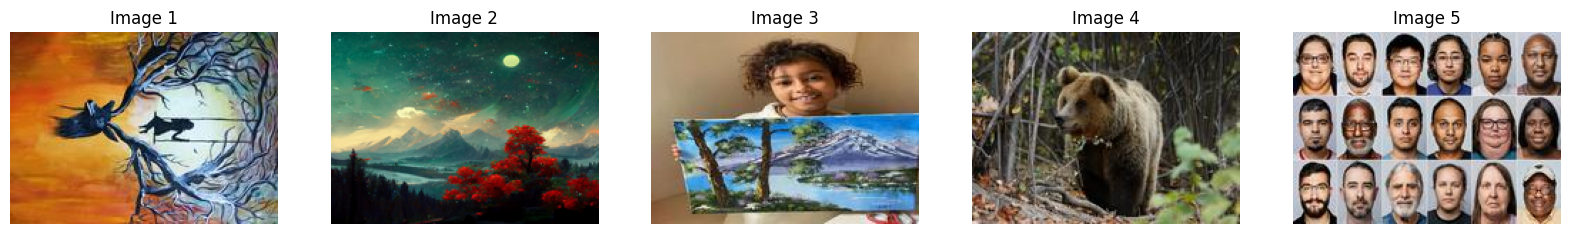

In [ ]:
#preview images from each class
print("Examples of Real Images:")
print() #blank space

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the selected images and plot each one
for i, image_name in enumerate(real_images[:5]):
    # Load the image
    img_path = os.path.join(real_folder, image_name)
    img = Image.open(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Image {i+1}")

# Display the plot
plt.show()

Examples of AI Images:



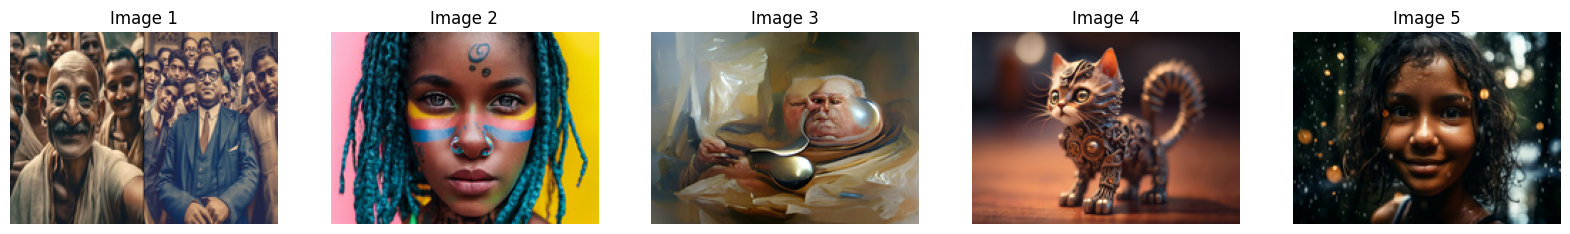

In [ ]:
print("Examples of AI Images:")
print() #blank space

# Create a figure to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through the selected images and plot each one
for i, image_name in enumerate(ai_images[:5]):
    # Load the image
    img_path = os.path.join(ai_folder, image_name)
    img = Image.open(img_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(f"Image {i+1}")

# Display the plot
plt.show()

 ## Split the data into train, validation, and test

In [ ]:
"""
#only run once
# Shuffle the images
random.shuffle(real_images)
random.shuffle(ai_images)

# Define the train-test split ratio
train_split_ratio = 0.7
val_split_ratio = 0.15

# Calculate the number of images for train and test
num_train_real = int(len(real_images) * train_split_ratio)
num_train_ai = int(len(ai_images) * train_split_ratio)
num_val_real = int(len(real_images) * val_split_ratio)
num_val_ai = int(len(ai_images) * val_split_ratio)

# Function to add image data to the list
def add_image_data(image_list, label, image_data):
    for img in image_list:
        image_data.append({'path': os.path.join(source_folder, label, img), 'label': label, 'image': Image.open(os.path.join(source_folder, label, img))})

In [ ]:
"""
#only run once
# Initialize lists
train_images_list = []
train_images_list_real = []
train_images_list_ai = []
train_image_data = []

# Move real images to train folder
for img in real_images[:num_train_real]:
    src_path = os.path.join(real_folder, img)
    dst_path = os.path.join(train_real, f'real_{img}')
    shutil.copy(src_path, dst_path)
    train_images_list_real.append(dst_path)
    add_image_data(train_images_list_real, 'real', train_image_data)

# Move ai images to train folder
for img in ai_images[:num_train_ai]:
    src_path = os.path.join(ai_folder, img)
    dst_path = os.path.join(train_ai, f'ai_{img}')
    shutil.copy(src_path, dst_path)
    train_images_list_ai.append(dst_path)
    add_image_data(train_images_list_ai, 'ai', train_image_data)

In [ ]:
"""
#only run once
# Initialize lists
val_images_list = []
val_images_list_real = []
val_images_list_ai = []
val_image_data = []

# Move real images to validation folder
for img in real_images[num_train_real:num_train_real+num_val_real]:
    src_path = os.path.join(real_folder, img)
    dst_path = os.path.join(val_real, f'real_{img}')
    shutil.copy(src_path, dst_path)
    val_images_list_real.append(dst_path)
    add_image_data(val_images_list_real, 'real', val_image_data)

# Move ai images to validation folder
for img in ai_images[num_train_ai:num_train_ai+num_val_ai]:
    src_path = os.path.join(ai_folder, img)
    dst_path = os.path.join(val_ai, f'ai_{img}')
    shutil.copy(src_path, dst_path)
    val_images_list_ai.append(dst_path)
    add_image_data(val_images_list_ai, 'ai', val_image_data)

In [ ]:
"""
#only run once
# Initialize lists
test_images_list = []
test_images_list_real = []
test_images_list_ai = []
test_image_data = []

# Move remaining real images to test folder
for img in real_images[num_train_real+num_val_real:]:
    src_path = os.path.join(real_folder, img)
    dst_path = os.path.join(test_real, f'real_{img}')
    shutil.copy(src_path, dst_path)
    test_images_list_real.append(dst_path)
    add_image_data(test_images_list_real, 'real', test_image_data)

# Move remaining ai images to test folder
for img in ai_images[num_train_ai+num_val_ai:]:
    src_path = os.path.join(ai_folder, img)
    dst_path = os.path.join(test_ai, f'ai_{img}')
    shutil.copy(src_path, dst_path)
    test_images_list_ai.append(dst_path)
    add_image_data(test_images_list_ai, 'ai', test_image_data)

In [ ]:
"""
#only run once
# Combine lists
train_images_list = train_images_list_real + train_images_list_ai
val_images_list = val_images_list_real + val_images_list_ai
test_images_list = test_images_list_real + test_images_list_ai

In [ ]:
"""
#only run once
# Determine how many files are in each folder
train_real_contents = os.listdir(train_real)
train_ai_contents = os.listdir(train_ai)
train_length = len(train_real_contents)+len(train_ai_contents)

val_real_contents = os.listdir(val_real)
val_ai_contents = os.listdir(val_ai)
val_length = len(val_real_contents)+len(val_ai_contents)

test_real_contents = os.listdir(test_real)
test_ai_contents = os.listdir(test_ai)
test_length = len(test_real_contents)+len(test_ai_contents)

In [ ]:
"""
#only run once
#check
print(f"Number of training images: ",train_length,"(real: ",len(train_real_contents),", ai: ",len(train_ai_contents),") / Number expected: ",num_train_real+num_train_ai,"(real: ",num_train_real,", ai: ",num_train_ai,")")
print(f"Number of validation images: ",val_length,"(real: ",len(val_real_contents),", ai: ",len(val_ai_contents),") / Number expected: ",num_val_real+num_val_ai,"(real: ",num_val_real,", ai: ",num_val_ai,")")
print(f"Number of testing images: ",test_length,"(real: ",len(test_real_contents),", ai: ",len(test_ai_contents),") / Number expected: ",num_val_real+num_val_ai,"(real: ",num_val_real,", ai: ",num_val_ai,")")

Number of training images:  660 (real:  294 , ai:  366 ) / Number expected:  660 (real:  294 , ai:  366 )
Number of validation images:  141 (real:  63 , ai:  78 ) / Number expected:  141 (real:  63 , ai:  78 )
Number of testing images:  144 (real:  64 , ai:  80 ) / Number expected:  141 (real:  63 , ai:  78 )


Note: it is fine test has more than expected because total images - train - validation = remaining all went to test.

 ## Data Processing

In [9]:
#image generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

In [10]:
train = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(min_height, min_width),
    class_mode='categorical',
    batch_size=1,
)

val = val_datagen.flow_from_directory(
    directory=val_folder,
    target_size=(min_height, min_width),
    class_mode='categorical',
    batch_size=1,
)

Found 656 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


In [11]:
# Create an ImageDataGenerator for test data (only rescaling)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create a generator for loading test images from the test directory
test = test_datagen.flow_from_directory(
    directory=test_folder,
    target_size=(min_height,min_width),
    class_mode='categorical',
    batch_size=1
)

Found 143 images belonging to 2 classes.


In [12]:
train_labels = train.classes
val_labels = val.classes
test_labels = test.classes

 ## Initial Classifier Build

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

Learning Rate: 1e-05
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 93, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 45, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 92160)             0         
                                                                 
 dense (Dense)               (None,

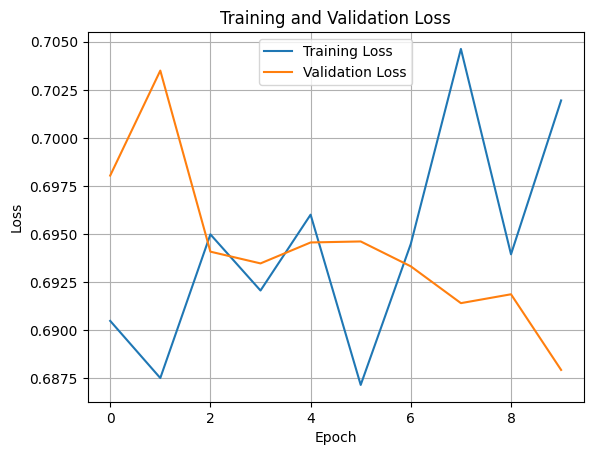

Learning Rate: 0.0001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 93, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 45, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 92160)             0         
                                                                 
 dense (Dense)               (None

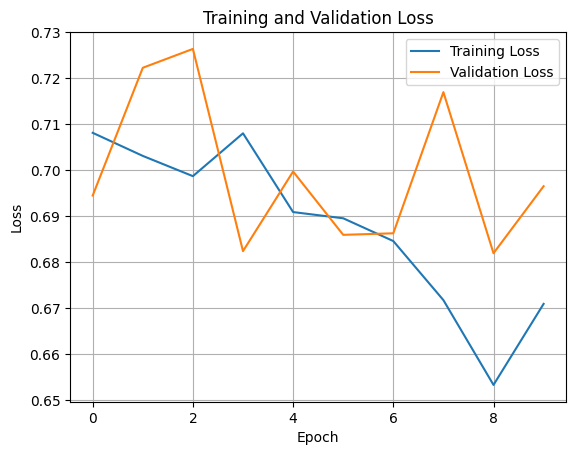

Learning Rate: 0.001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 93, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 45, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 92160)             0         
                                                                 
 dense (Dense)               (None,

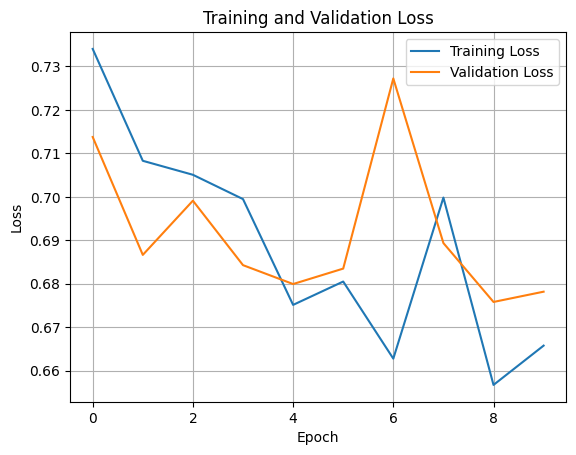

Learning Rate: 0.01
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 93, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 45, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 92160)             0         
                                                                 
 dense (Dense)               (None, 

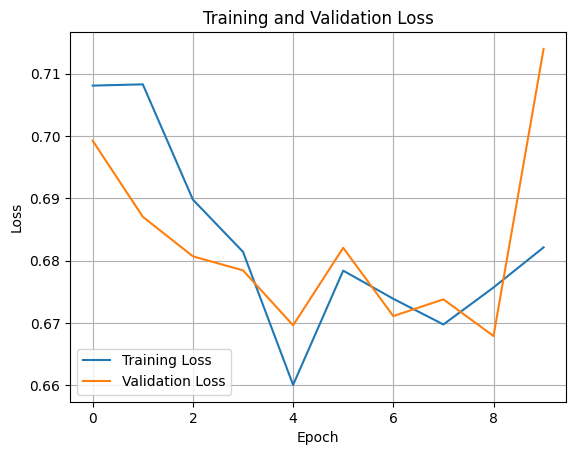

Learning Rate: 0.1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 93, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 45, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 92160)             0         
                                                                 
 dense (Dense)               (None, 2

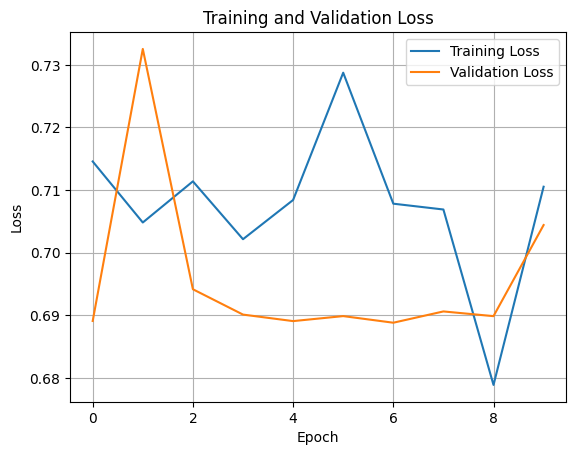

Learning Rate: 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 186, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 93, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 91, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 45, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 92160)             0         
                                                                 
 dense (Dense)               (None, 256

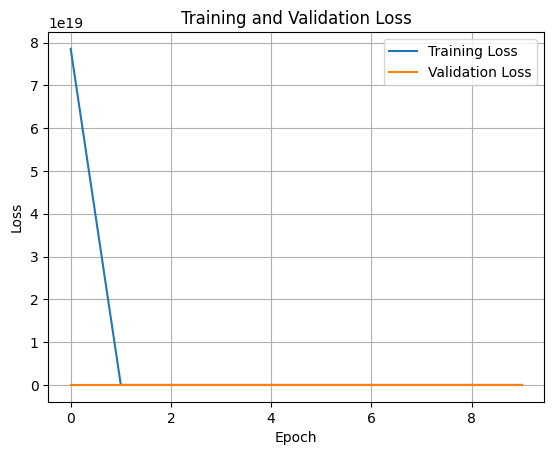

In [ ]:
# Compile the model, testing different learning rates
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
for rate in learning_rates:
  print(f"Learning Rate:",rate)
  model.compile(optimizer=SGD(learning_rate=rate), loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  #quick test
  history = model.fit(train, epochs=10, steps_per_epoch=100, validation_data=val)
  test_predictions = model.predict(test)
  test_predicted_classes = np.argmax(test_predictions, axis=1)
  test_accuracy = accuracy_score(test_labels, test_predicted_classes)
  print(f"Test Accuracy: ",test_accuracy)
  train_predictions = model.predict(train)
  train_predicted_classes = np.argmax(train_predictions, axis=1)
  train_accuracy = accuracy_score(train_labels, train_predicted_classes)
  print(f"Train Accuracy: ",train_accuracy)
  print(f"Accuracy Difference: ",train_accuracy - test_accuracy)
  # Plot loss for quick test
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

 ## Model Runs

In [ ]:
#compile
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

results = []
#try combinations of steps_per_epoch 10-500 and epochs 1-30
combos = [
    (10, 1, 1),
    (10, 5, 2),
    (10, 10, 3),
    (10, 30, 4),
    (50, 1, 5),
    (50, 5, 6),
    (50, 10, 7),
    (50, 30, 8),
    (100, 1, 9),
    (100, 5, 10),
    (100, 10, 11),
    (100, 30, 12),
    (250, 1, 13),
    (250, 5, 14),
    (250, 10, 15),
    (250, 30, 16),
    (500, 1, 17),
    (500, 5, 18),
    (500, 10, 19),
    (500, 30, 20)
]

for steps, epochs, i in combos:
    print(f"Training with steps_per_epoch={steps} and epochs={epochs}")
    history = model.fit(train, epochs=epochs, steps_per_epoch=steps, validation_data=val)
    test_predictions = model.predict(test)
    test_predicted_classes = np.argmax(test_predictions, axis=1)
    test_accuracy = accuracy_score(test_labels, test_predicted_classes)
    train_predictions = model.predict(train)
    train_predicted_classes = np.argmax(train_predictions, axis=1)
    train_accuracy = accuracy_score(train_labels, train_predicted_classes)
    abs_acc_diff = abs(train_accuracy - test_accuracy)
    train_loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    abs_loss_diff= abs(train_loss - val_loss)
    results.append({
        'Steps_per_epoch': steps,
        'Epochs': epochs,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Absolute Accuracy Difference': abs_acc_diff,
        'Train Loss': train_loss,
        'Validation Loss': val_loss,
        'Absolute Loss Difference': abs_loss_diff
    })

Training with steps_per_epoch=10 and epochs=1
656/656 [==============================] - 20s 30ms/step
Training with steps_per_epoch=10 and epochs=5
Epoch 1/5
10/10 [==============================] - 8s 847ms/step - loss: 0.7376 - accuracy: 0.5000 - val_loss: 0.7276 - val_accuracy: 0.5745
Epoch 2/5
10/10 [==============================] - 5s 532ms/step - loss: 0.7578 - accuracy: 0.5000 - val_loss: 0.7061 - val_accuracy: 0.5532
Epoch 3/5
10/10 [==============================] - 7s 715ms/step - loss: 0.6971 - accuracy: 0.6000 - val_loss: 0.6944 - val_accuracy: 0.5745
Epoch 4/5
10/10 [==============================] - 7s 718ms/step - loss: 0.5253 - accuracy: 0.7000 - val_loss: 0.6867 - val_accuracy: 0.5816
Epoch 5/5
656/656 [==============================] - 22s 33ms/step
Training with steps_per_epoch=10 and epochs=10
Epoch 1/10
10/10 [==============================] - 7s 723ms/step - loss: 0.4810 - accuracy: 0.8000 - val_loss: 0.6756 - val_accuracy: 0.5816
Epoch 2/10
10/10 [=============

In [ ]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results)
pd.set_option('display.width', 1000)  # Set the display width to prevent wrapping onto new lines

In [ ]:
print("Largest Test Accuracy:")
print(results_df.sort_values(by='Test Accuracy', ascending=False).head(1))

Largest Test Accuracy:
   Steps_per_epoch  Epochs  Train Accuracy  Test Accuracy  Absolute Accuracy Difference  Train Loss  Validation Loss  Absolute Loss Difference
1               10       5        0.554878       0.573427                      0.018549    0.737616         0.727614                  0.010002


In [ ]:
#Review the results
print("Smallest Difference Between Train and Test Accuracy:")
print(results_df.sort_values(by='Absolute Accuracy Difference').head(1))

Smallest Difference Between Train and Test Accuracy:
    Steps_per_epoch  Epochs  Train Accuracy  Test Accuracy  Absolute Accuracy Difference  Train Loss  Validation Loss  Absolute Loss Difference
14              250      10        0.493902       0.496503                      0.002601    0.511023         0.607076                  0.096053


In [ ]:
print("Smallest Difference Between Train and Validation Loss:")
print(results_df.sort_values(by='Absolute Loss Difference').head(1))

Smallest Difference Between Train and Validation Loss:
   Steps_per_epoch  Epochs  Train Accuracy  Test Accuracy  Absolute Accuracy Difference  Train Loss  Validation Loss  Absolute Loss Difference
7               50      30        0.480183       0.503497                      0.023314    0.656466         0.646494                  0.009972


In [ ]:
print("All Results:")
print(results_df.sort_values(by='Test Accuracy', ascending=False))

All Results:
    Steps_per_epoch  Epochs  Train Accuracy  Test Accuracy  Absolute Accuracy Difference  Train Loss  Validation Loss  Absolute Loss Difference
1                10       5        0.554878       0.573427                      0.018549    0.737616         0.727614                  0.010002
10              100      10        0.500000       0.566434                      0.066434    0.523871         0.613431                  0.089561
9               100       5        0.522866       0.566434                      0.043568    0.530765         0.687679                  0.156914
0                10       1        0.553354       0.559441                      0.006087    0.391402         0.787689                  0.396287
11              100      30        0.503049       0.552448                      0.049399    0.502502         0.645248                  0.142746
5                50       5        0.568598       0.545455                      0.023143    0.579605         0.666332      

In [ ]:
#plot loss for best performing models
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model2 = model.fit(train, epochs=5, steps_per_epoch=10, validation_data=val) #largest test accuracy
model3 = model.fit(train, epochs=5, steps_per_epoch=50, validation_data=val) #largest train accuracy
model4 = model.fit(train, epochs=30, steps_per_epoch=50, validation_data=val) #smallest loss difference

Epoch 1/5
10/10 [==============================] - 57s 6s/step - loss: 0.7144 - accuracy: 0.5000 - val_loss: 0.7709 - val_accuracy: 0.4468
Epoch 2/5
10/10 [==============================] - 5s 577ms/step - loss: 0.6200 - accuracy: 0.7000 - val_loss: 0.8795 - val_accuracy: 0.4468
Epoch 3/5
10/10 [==============================] - 13s 1s/step - loss: 0.7997 - accuracy: 0.4000 - val_loss: 0.7530 - val_accuracy: 0.4468
Epoch 4/5
10/10 [==============================] - 7s 774ms/step - loss: 0.7355 - accuracy: 0.4000 - val_loss: 0.7021 - val_accuracy: 0.5532
Epoch 5/5
10/10 [==============================] - 5s 555ms/step - loss: 0.7478 - accuracy: 0.6000 - val_loss: 0.6902 - val_accuracy: 0.5532
Epoch 1/5
50/50 [==============================] - 22s 445ms/step - loss: 0.6951 - accuracy: 0.6200 - val_loss: 0.6861 - val_accuracy: 0.5390
Epoch 2/5
50/50 [==============================] - 16s 317ms/step - loss: 0.7180 - accuracy: 0.4400 - val_loss: 0.6924 - val_accuracy: 0.5674
Epoch 3/5
50/50

Epochs:  5  Steps Per Epoch:  10


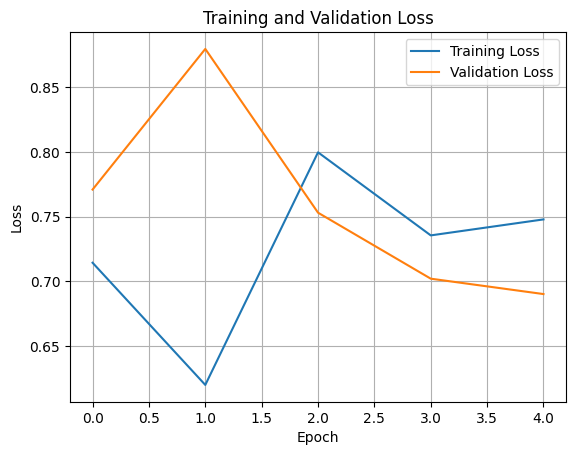

Epochs:  5  Steps Per Epoch:  50


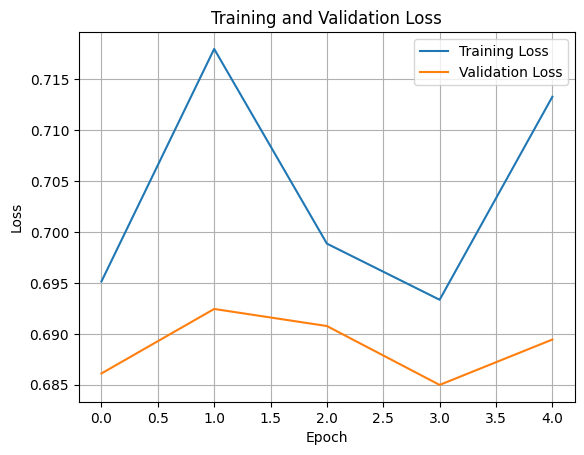

Epochs:  30  Steps Per Epoch:  50


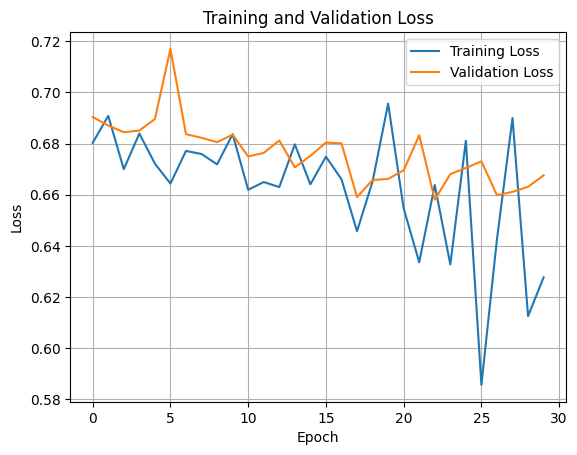

In [ ]:
model_list = [model2, model3, model4]
for m in model_list:
  print(f"Epochs: ",m.params['epochs']," Steps Per Epoch: ",m.params['steps'])
  plt.plot(m.history['loss'], label='Training Loss')
  plt.plot(m.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

 ## Determine if Model with Best Performance Improves Further with Early Stopping

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

#compile
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
# Train the model with early stopping
best_earlystop = model.fit(train, epochs=30, steps_per_epoch=50, validation_data=val, callbacks=[early_stopping])

Epoch 1/30
50/50 [==============================] - 15s 282ms/step - loss: 0.7282 - accuracy: 0.4600 - val_loss: 0.6947 - val_accuracy: 0.5177
Epoch 2/30
50/50 [==============================] - 13s 271ms/step - loss: 0.7320 - accuracy: 0.3800 - val_loss: 0.6903 - val_accuracy: 0.5816
Epoch 3/30
50/50 [==============================] - 15s 296ms/step - loss: 0.6971 - accuracy: 0.5200 - val_loss: 0.6902 - val_accuracy: 0.6099
Epoch 4/30
50/50 [==============================] - 12s 251ms/step - loss: 0.7045 - accuracy: 0.5000 - val_loss: 0.6907 - val_accuracy: 0.5461
Epoch 5/30
50/50 [==============================] - 13s 262ms/step - loss: 0.6996 - accuracy: 0.5800 - val_loss: 0.6908 - val_accuracy: 0.5461
Epoch 6/30
50/50 [==============================] - 14s 280ms/step - loss: 0.6868 - accuracy: 0.5000 - val_loss: 0.7040 - val_accuracy: 0.4468


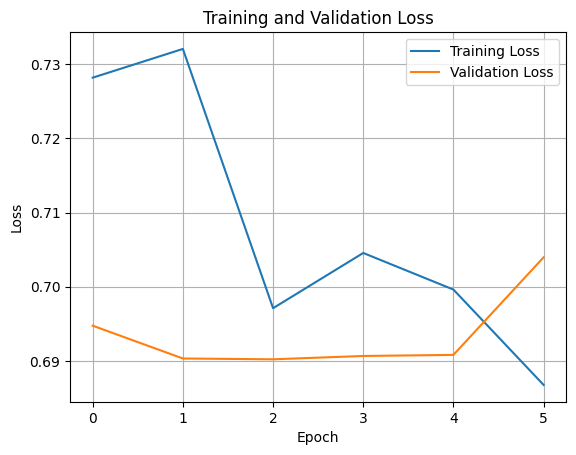

In [ ]:
plt.plot(best_earlystop.history['loss'], label='Training Loss')
plt.plot(best_earlystop.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Predict using the saved model and the test generator
predictions_earlystop = model.predict(test)

# Convert predictions to class labels
predicted_classes_earlystop = np.argmax(predictions_earlystop, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_earlystop)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_earlystop)
print("Test Accuracy:", test_accuracy)

143/143 [==============================] - 50s 352ms/step
Predicted class labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0]
Test Accuracy: 0.5384615384615384


Test Accuracy improved with early stopping

What about dropout?

Epoch 1/30
50/50 [==============================] - 19s 365ms/step - loss: 0.7448 - accuracy: 0.4200 - val_loss: 0.8081 - val_accuracy: 0.5532
Epoch 2/30
50/50 [==============================] - 14s 288ms/step - loss: 0.7947 - accuracy: 0.4000 - val_loss: 0.6915 - val_accuracy: 0.5532
Epoch 3/30
50/50 [==============================] - 14s 291ms/step - loss: 0.6664 - accuracy: 0.6200 - val_loss: 0.6911 - val_accuracy: 0.5532
Epoch 4/30
50/50 [==============================] - 20s 399ms/step - loss: 0.7309 - accuracy: 0.4600 - val_loss: 0.7010 - val_accuracy: 0.5532
Epoch 5/30
50/50 [==============================] - 14s 291ms/step - loss: 0.7334 - accuracy: 0.4000 - val_loss: 0.6909 - val_accuracy: 0.5603
Epoch 6/30
50/50 [==============================] - 14s 275ms/step - loss: 0.7058 - accuracy: 0.5200 - val_loss: 0.6875 - val_accuracy: 0.5532
Epoch 7/30
50/50 [==============================] - 13s 267ms/step - loss: 0.7013 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.5319

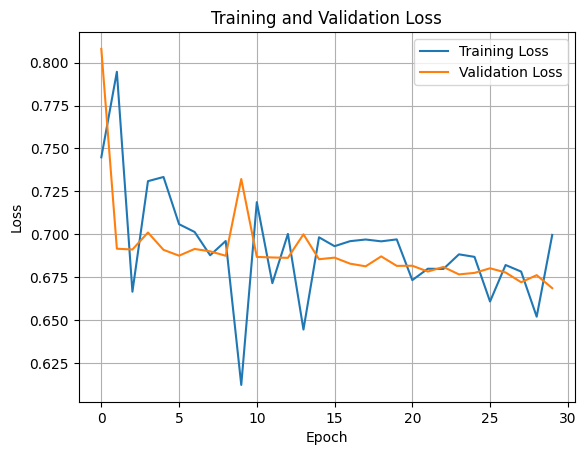

143/143 [==============================] - 3s 23ms/step
Predicted class labels: [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Test Accuracy: 0.4825174825174825


In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

#compile
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
best_dropout = model.fit(train, epochs=30, steps_per_epoch=50, validation_data=val)

#plot loss
plt.plot(best_dropout.history['loss'], label='Training Loss')
plt.plot(best_dropout.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the saved model and the test generator
predictions_dropout = model.predict(test)

# Convert predictions to class labels
predicted_classes_dropout = np.argmax(predictions_dropout, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_dropout)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_dropout)
print("Test Accuracy:", test_accuracy)

What about dropout AND early stopping?

Epoch 1/30
50/50 [==============================] - 50s 998ms/step - loss: 0.7450 - accuracy: 0.5600 - val_loss: 0.6962 - val_accuracy: 0.4610
Epoch 2/30
50/50 [==============================] - 16s 322ms/step - loss: 0.7130 - accuracy: 0.4600 - val_loss: 0.7174 - val_accuracy: 0.4397
Epoch 3/30
50/50 [==============================] - 16s 320ms/step - loss: 0.7623 - accuracy: 0.4000 - val_loss: 0.7092 - val_accuracy: 0.4397
Epoch 4/30
50/50 [==============================] - 17s 333ms/step - loss: 0.7023 - accuracy: 0.5200 - val_loss: 0.6879 - val_accuracy: 0.5461
Epoch 5/30
50/50 [==============================] - 16s 314ms/step - loss: 0.6994 - accuracy: 0.5400 - val_loss: 0.6917 - val_accuracy: 0.5532
Epoch 6/30
50/50 [==============================] - 16s 319ms/step - loss: 0.6603 - accuracy: 0.6600 - val_loss: 0.6936 - val_accuracy: 0.5532
Epoch 7/30
50/50 [==============================] - 16s 318ms/step - loss: 0.6744 - accuracy: 0.6800 - val_loss: 0.7221 - val_accuracy: 0.5532

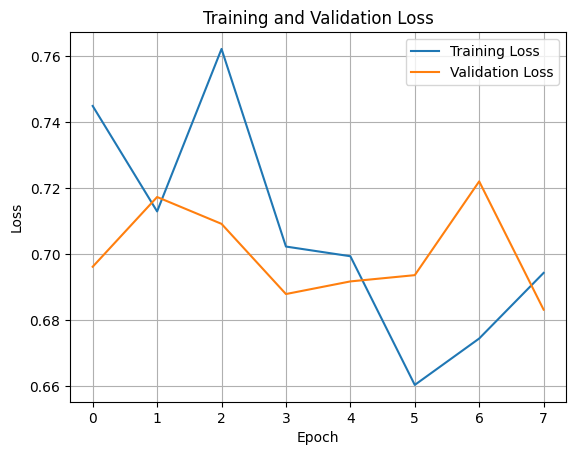

143/143 [==============================] - 36s 254ms/step
Predicted class labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Test Accuracy: 0.5524475524475524


In [15]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(min_height, min_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

#compile
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

#fit
early_and_drop = model.fit(train, epochs=30, steps_per_epoch=50, validation_data=val, callbacks=[early_stopping])

#plot loss
plt.plot(early_and_drop.history['loss'], label='Training Loss')
plt.plot(early_and_drop.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predict using the saved model and the test generator
predictions_early_and_drop = model.predict(test)

# Convert predictions to class labels
predicted_classes_early_and_drop = np.argmax(predictions_early_and_drop, axis=1)

# Print the predicted class labels
print("Predicted class labels:", predicted_classes_early_and_drop)

#accuracy calc
test_accuracy = accuracy_score(test_labels, predicted_classes_early_and_drop)
print("Test Accuracy:", test_accuracy)

In [16]:
#additional metrics for best model
# Predict using the saved model and the test generator
predictions_early_and_drop_train = model.predict(train)

# Convert predictions to class labels
predicted_classes_early_and_drop_train = np.argmax(predictions_early_and_drop_train, axis=1)

#accuracy calc
train_accuracy = accuracy_score(train_labels, predicted_classes_early_and_drop_train)
print("Train Accuracy:", train_accuracy)

656/656 [==============================] - 26s 39ms/step
Train Accuracy: 0.5564024390243902


In [17]:
#loss
train_loss_best = early_and_drop.history['loss'][0]
print("Train Loss: ",train_loss_best)
val_loss_best = early_and_drop.history['val_loss'][0]
print("Validation Loss: ",val_loss_best)

Train Loss:  0.744987964630127
Validation Loss:  0.6961896419525146


The model above is the best one, to be tested on a larger dataset.